# Exploring `base_network.py` outputs

This jupyter notebook analyse the `base_network.py` **outputs**.

The `pypsa-earth/Snakefile` explicitly list in the **rule** what goes into the function `base_network.py` and what goes out (`networks/base.nc`). When inputs are commented out (#) than they are currently not considered. Maybe you want to delete them, make them run or develop new features? What can be observed from the inputs is that the script creates a connected network topology with the network data and shapes of the region.

```
rule base_network:
    input:
        osm_buses="data/base_network/africa_all_buses_build_network.csv",
        osm_lines="data/base_network/africa_all_lines_build_network.csv",
        country_shapes='resources/country_shapes.geojson',
        offshore_shapes='resources/offshore_shapes.geojson',
        # eg = ENTSO-E Gridkit
        # eg_buses='data/entsoegridkit/buses.csv',
        # eg_lines='data/entsoegridkit/lines.csv',
        # eg_links='data/entsoegridkit/links.csv',
        # eg_converters='data/entsoegridkit/converters.csv',
        # eg_transformers='data/entsoegridkit/transformers.csv',
        # parameter_corrections='data/parameter_corrections.yaml',
        # links_p_nom='data/links_p_nom.csv',
        # links_tyndp='data/links_tyndp.csv',
        # africa_shape='resources/africa_shape.geojson'
    output:
        "networks/base.nc",
    log:
        "logs/base_network.log",
    benchmark:
        "benchmarks/base_network"
    threads: 1
    resources:
        mem=500,
    script:
        "scripts/base_network.py"
```

Before analysing the outputs of add_electricity.py check that:
- `pypsa-earth` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-earth is installed is named "pypsa-earth"
- or rename the below `sets_path_to_root("<folder_name>")` accordingly

In [1]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
from _helpers import sets_path_to_root

sets_path_to_root("pypsa-earth-project")

This is the repository path:  /home/anas/EDF/pypsa-earth-project
Had to go 2 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-earth` environment:

In [ ]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib as plt

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

logger = logging.getLogger(__name__)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

## Network analysis

Now let's import the output file which should be in i.e. `~/pypsa-earth/networks/base.nc`. 

Note: If you don't have the /elec.nc file yet in your folder structure, you could try to generate it from the terminal. In this case set the path so that you are located at `~/pypsa-earth`. Once you are there, use the command:
```
snakemake -j 1 networks/base.nc
```
Note that this is something you can to for any other rule to generate it's outputs `snakemake -j 1 <output of rule>`

In [3]:
network_path = os.getcwd() + "/pypsa-earth/networks/base.nc"
n = pypsa.Network(network_path)
n

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 257
 - Line: 245
 - Transformer: 30
Snapshots: 8760

You might be interested to see what's in the Network Common Data Form or NetCDF (.nc) file. To assess that we use **xarray**

In [4]:
import xarray as xr

path = os.getcwd() + "/pypsa-earth/networks/base.nc"
network_data = xr.open_dataset(path)
network_data

<xarray.Dataset>
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   buses_i: 257, transformers_i: 30,
                                   lines_i: 245)
Coordinates:
  * snapshots                     (snapshots) int64 0 1 2 3 ... 8757 8758 8759
  * investment_periods            (investment_periods) float64 
  * buses_i                       (buses_i) object '0' '1' '2' ... '255' '256'
  * transformers_i                (transformers_i) object 'transf_1_0' ... 't...
  * lines_i                       (lines_i) object '564729320-1_0' ... '21545...
Data variables: (12/56)
    snapshots_snapshot            (snapshots) datetime64[ns] ...
    snapshots_objective           (snapshots) float64 ...
    snapshots_stores              (snapshots) float64 ...
    snapshots_generators          (snapshots) float64 ...
    investment_periods_objective  (investment_periods) float64 ...
    investment_periods_years      (investment_periods) float64 ...
    ...                            ...
    lines_bus0_lat                (lines_i) float64 ...
    lines_bus1_lon                (lines_i) float64 ...
    lines_bus1_lat                (lines_i) float64 ...
    lines_type                    (lines_i) object ...
    lines_s_max_pu                (lines_i) float64 ...
    lines_s_nom                   (lines_i) float64 ...
Attributes:
    network_name:           PyPSA-Eur
    network_pypsa_version:  0.20.1
    network_srid:           4326
    meta:                   {}

In [5]:
n.buses.head(2)

,bus_id,v_nom,symbol,under_construction,tag_substation,tag_area,lon,lat,country,substation_lv,x,y,substation_off,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,,,,,,,,,,,
0,0,220.0,substation,False,transmission,0.0,6.6507,5.0669,NG,True,6.6507,5.0669,True,,AC,None,1.0,0.0,inf,PQ,
1,1,220.0,substation,False,transmission,0.0,5.6343,6.2963,NG,True,5.6343,6.2963,True,,AC,None,1.0,0.0,inf,PQ,


Example to check the input:

<AxesSubplot:>

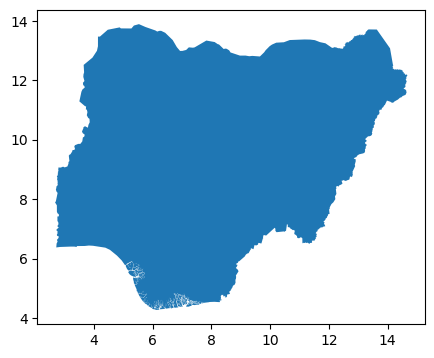

In [6]:
regions = (
    os.getcwd() + "/pypsa-earth/resources/shapes/country_shapes.geojson"
)  # path of the input as shown in the Snakefile
gpd.read_file(regions).plot(figsize=(5,5))

That's how the raw data looks like:

In [7]:
gpd.read_file(regions)

,name,geometry
0,NG,"MULTIPOLYGON (((6.43875 4.39375, 6.44764 4.41736, 6.45347 4.40819,..."


Checking which countries are considered:

In [8]:
n.buses["country"].unique()

array(['NG'], dtype=object)

Looking at the lines you find out that some of the names at the end of the pandadataframe are quite long. These are articifial created lines that create a connected network topology:

In [9]:
n.lines.head(2)

,bus0,bus1,v_nom,num_parallel,length,underground,under_construction,tag_type,tag_frequency,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,type,s_max_pu,s_nom,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
564729320-1_0,0,201,220.0,1.0,5.010445,False,False,line,50,NG,"LINESTRING (6.6507 5.0669, 6.650698800000018 5.066925700000043, 6....","MULTIPOINT (6.6507 5.0669, 6.6913 5.0619)",POINT (6.6507 5.0669),POINT (6.6913 5.0619),6.6507,5.0669,6.6913,5.0619,Al/St 240/40 2-bundle 220.0,0.7,491.556019,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546624332-1_0,2,195,300.0,2.0,6.434654,False,False,line,50,NG,"LINESTRING (5.6353 6.2973, 5.6360829 6.2959648, 5.6394464 6.294203...","MULTIPOINT (5.6353 6.2973, 5.679 6.3064)",POINT (5.6353 6.2973),POINT (5.679 6.3064),5.6353,6.2973,5.6790,6.3064,Al/St 240/40 3-bundle 300.0,0.7,2010.910988,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Check hv.plot (need to be fixed)

In [10]:
# Issue probably with ["geometry"]
n.lines["geometry"].head(2)  # .apply(wkt.loads)

Line
564729320-1_0    LINESTRING (6.6507 5.0669, 6.650698800000018 5.066925700000043, 6....
546624332-1_0    LINESTRING (5.6353 6.2973, 5.6360829 6.2959648, 5.6394464 6.294203...
Name: geometry, dtype: object

In [11]:
from shapely import wkt

lines = n.lines
lines["geometry"] = lines["geometry"].apply(wkt.loads)
lines = gpd.GeoDataFrame(lines, crs="epsg:4326")

buses = n.buses
buses["geometry"] = gpd.points_from_xy(buses.lon, buses.lat)
buses = gpd.GeoDataFrame(buses, crs="epsg:4326")

In [12]:
lines = lines[lines["country"] == "NG"]
buses = buses[buses["country"] == "NG"]

basa_network = buses.hvplot(
    geo=True,
    size=10,  # buses["tag_area"]**(0.5)/10,
    frame_height=750,
    alpha=0.4,
    tiles="CartoLight",
    hover_cols=["bus_id"],
    color="orange",
) * lines.hvplot(geo=True, alpha=0.4, hover_cols=["line_id"]).opts(
    active_tools=["pan", "wheel_zoom"]
)
# display(basa_network) # show the plot in the notebook
hvplot.save(basa_network, "documentation/base_network_buses_lines.html");